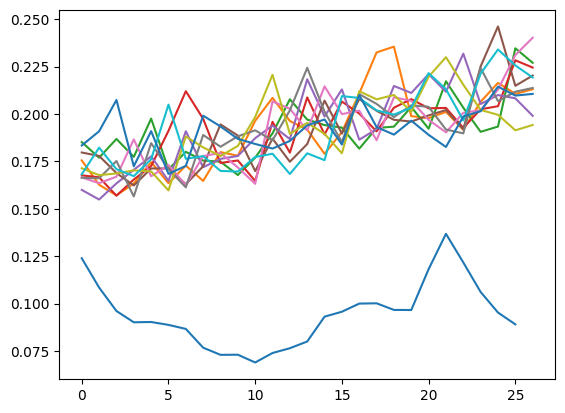

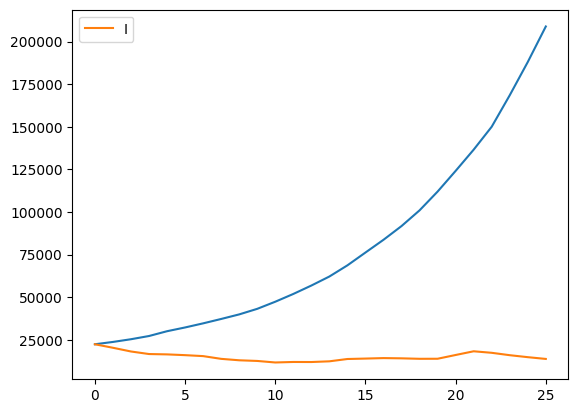

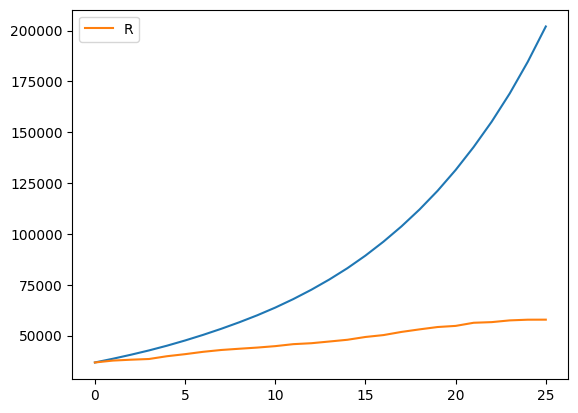

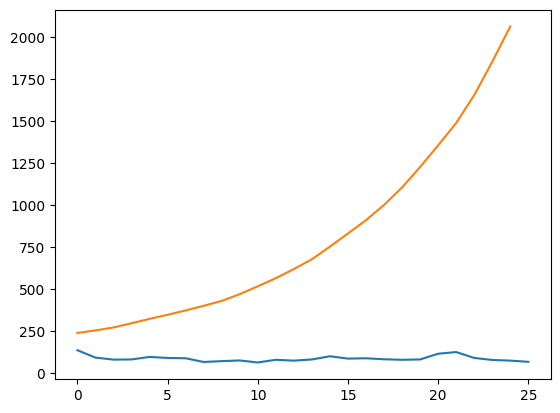

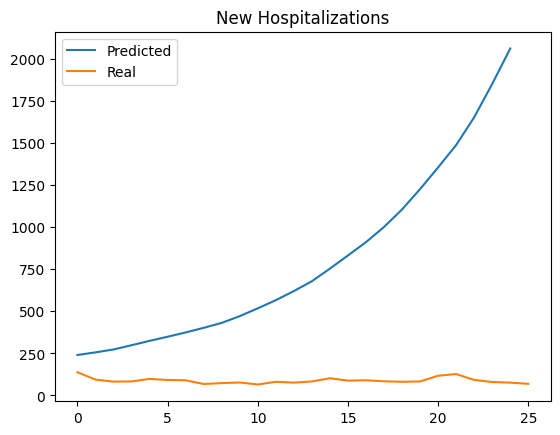

In [2]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd

state = "AZ"

predicted_beta = pd.read_csv('../datasets/out_beta_trj_bootp.csv').to_numpy()
predicted_beta = np.delete(predicted_beta,0,1)

observations = pd.read_csv(f'../datasets/{state}_FLU_HOSPITALIZATIONS.csv').to_numpy()
observations = np.delete(observations,0,1)

estimated_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
estimated_state = np.delete(estimated_state,0,1)

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1)


t_span = [65,91]

plt.plot(pf_beta[t_span[0]:t_span[1]])
#plt.plot([p_beta(t) for t in range(26)])
for i in range(10):
    plt.plot(predicted_beta[i,:])
plt.show()



def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

def Jacobian(t,state,par):

    S,I,R,H,new_H = state
    N = S + I + R + H #compute the total population 
    return np.array([[-I*par.beta(int(t))/N,
                        -S*par.beta(int(t))/N,
                        1/par.L,0,0,],
                        [I*par.beta(int(t))/N,
                        S*par.beta(int(t))/N - 1/par.D,0,0,0,],
                        [0,(1 - par.gamma)/par.D,
                        -1/par.L,1/par.hosp,0,],
                        [0,par.gamma/par.D,0,
                        -1/par.hosp,0,],
                        [0,par.gamma/par.D,0,0,0,],])





def beta(t):
    return predicted_beta[50,int(t-t_span[0])]



state = estimated_state[t_span[0],:]
y0 = np.concatenate((state,observations[round(t_span[0])]))


par={
"beta":beta,
"gamma":0.1,
"hosp":10,
"L":90,
"D":10}

sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,par), 
                    jac=lambda t,z:Jacobian(t,z,par), 
                    t_span=t_span,
                    t_eval= np.linspace(t_span[0],t_span[1],num=round(t_span[1] - t_span[0])),
                    y0=y0,
                    method='LSODA')

labels = ['S','I','R','H']
for i in range(1,3):
    plt.plot(sol.y[i,:])
    plt.plot(estimated_state[round(t_span[0]):round(t_span[1]),i],label = labels[i])
    plt.legend()
    plt.show()

plt.plot(observations[round(t_span[0]):round(t_span[1])])
plt.plot(np.diff(sol.y[4,:]))
plt.show()

par_p={
"beta":beta,
"gamma":0.1,
"hosp":15,
"L":90,
"D":10}


y0 = np.concatenate((state,observations[t_span[0]]))
sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,par_p), 
                    jac=lambda t,z:Jacobian(t,z,par_p), 
                    t_span=t_span,
                    t_eval= np.linspace(t_span[0],t_span[1],num=26),
                    y0=y0,
                    method='LSODA')

plt.title('New Hospitalizations')
plt.plot(np.diff(sol.y[4,:]),label = "Predicted")
plt.plot(observations[t_span[0]:t_span[1]],label = "Real")
plt.legend()
plt.show()

